# Project Requirements 2 & 3: Algorithm Comparison

This notebook demonstrates the implementation of Project Requirements 2 and 3 using specialized seller classes:

- **Requirement 2**: Multiple products + stochastic environment + Combinatorial-UCB
- **Requirement 3**: Single product + best-of-both-worlds + Primal-Dual

Both algorithms use the project-compliant binary demand model and corrected reward calculations.

In [1]:
# Import required libraries and modules
import numpy as np
import matplotlib.pyplot as plt
from base_classes.setting import Setting
from base_classes.environment import Environment
from base_classes.specialized_sellers import create_seller_for_requirement

# Set random seed for reproducible results
np.random.seed(42)

print("📚 Libraries imported and environment configured")
print("🎯 Ready to run Project Requirements 2 & 3")

📚 Libraries imported and environment configured
🎯 Ready to run Project Requirements 2 & 3


## Requirement 2: Multiple Products + Combinatorial-UCB

**Configuration:**
- Multiple products (N=3)
- Stochastic environment (stationary)
- CombinatorialUCBSeller with inventory constraint
- Discrete price set with 5 levels

In [2]:
# ✅ REQUIREMENT 2: Multiple products with Combinatorial-UCB
print("🏗️  REQUIREMENT 2: MULTIPLE PRODUCTS + COMBINATORIAL-UCB")
print("-" * 50)

req2_setting = Setting(
    T=500,
    n_products=3,  # Multiple products as required
    epsilon=0.2,   # Discrete price set (5 levels)
    distribution='gaussian',  # Stochastic environment
    dist_params=(50, 15),     # Distribution parameters
    verbose='no',
    budget_constraint="strict",  # Inventory constraint B
    non_stationary='no',      # Stochastic (stationary)
    algorithm="combinatorial_ucb"
)

# Create environment with specialized seller
req2_env = Environment(req2_setting)
req2_env.seller = create_seller_for_requirement(2, req2_setting)

print(f"Configuration:")
print(f"  - Products: {req2_setting.n_products}")
print(f"  - Price levels: {int(1/req2_setting.epsilon)}")
print(f"  - Environment: Stochastic (stationary)")
print(f"  - Seller: {req2_env.seller.__class__.__name__}")
print(f"  - Budget constraint: {req2_setting.B:.2f}")

# Run experiment
print(f"\n🚀 Running Requirement 2 experiment...")
req2_env.play_all_rounds()

# Calculate results
req2_rewards = np.array(req2_env.seller.history_rewards)
req2_regrets = req2_env.optimal_rewards - req2_rewards
req2_cum_regret = np.cumsum(req2_regrets)

print(f"✅ Requirement 2 completed!")
print(f"   Final cumulative regret: {req2_cum_regret[-1]:.2f}")
print(f"   Total rewards: {np.sum(req2_rewards):.2f}")
print(f"   Efficiency: {(np.sum(req2_rewards)/np.sum(req2_env.optimal_rewards)*100):.1f}%")

🏗️  REQUIREMENT 2: MULTIPLE PRODUCTS + COMBINATORIAL-UCB
--------------------------------------------------
Configuration:
  - Products: 3
  - Price levels: 5
  - Environment: Stochastic (stationary)
  - Seller: CombinatorialUCBSeller
  - Budget constraint: 45.83

🚀 Running Requirement 2 experiment...
✅ Requirement 2 completed!
   Final cumulative regret: 941.72
   Total rewards: 557.28
   Efficiency: 37.2%


## Requirement 3: Single Product + Primal-Dual

**Configuration:**
- Single product (N=1)
- Best-of-both-worlds: highly non-stationary environment
- PrimalDualSeller with inventory constraint
- Handles both stationary and adversarial settings

In [3]:
# ✅ REQUIREMENT 3: Single product with primal-dual for non-stationary
print("🏗️  REQUIREMENT 3: SINGLE PRODUCT + PRIMAL-DUAL")
print("-" * 50)

req3_setting = Setting(
    T=500,
    n_products=1,  # Single product as required
    epsilon=0.2,   # Discrete price set (5 levels)
    distribution='gaussian',  # Stochastic base
    dist_params=(50, 15),
    verbose='no',
    budget_constraint="strict",  # Inventory constraint B
    non_stationary='highly',  # Highly non-stationary environment
    algorithm="primal_dual"
)

# Create environment with specialized seller
req3_env = Environment(req3_setting)
req3_env.seller = create_seller_for_requirement(3, req3_setting)

print(f"Configuration:")
print(f"  - Products: {req3_setting.n_products} (single product)")
print(f"  - Price levels: {int(1/req3_setting.epsilon)}")
print(f"  - Environment: Highly non-stationary")
print(f"  - Seller: {req3_env.seller.__class__.__name__}")
print(f"  - Budget constraint: {req3_setting.B:.2f}")

# Run experiment
print(f"\n🚀 Running Requirement 3 experiment...")
req3_env.play_all_rounds()

# Calculate results
req3_rewards = np.array(req3_env.seller.history_rewards)
req3_regrets = req3_env.optimal_rewards - req3_rewards
req3_cum_regret = np.cumsum(req3_regrets)

print(f"✅ Requirement 3 completed!")
print(f"   Final cumulative regret: {req3_cum_regret[-1]:.2f}")
print(f"   Total rewards: {np.sum(req3_rewards):.2f}")
print(f"   Efficiency: {(np.sum(req3_rewards)/np.sum(req3_env.optimal_rewards)*100):.1f}%")

🏗️  REQUIREMENT 3: SINGLE PRODUCT + PRIMAL-DUAL
--------------------------------------------------
Configuration:
  - Products: 1 (single product)
  - Price levels: 5
  - Environment: Highly non-stationary
  - Seller: PrimalDualSeller
  - Budget constraint: 137.50

🚀 Running Requirement 3 experiment...
✅ Requirement 3 completed!
   Final cumulative regret: 100.03
   Total rewards: 44.08
   Efficiency: 30.6%
✅ Requirement 3 completed!
   Final cumulative regret: 100.03
   Total rewards: 44.08
   Efficiency: 30.6%


## Performance Comparison

Compare the performance of both algorithms in their respective optimal environments.

📊 PERFORMANCE COMPARISON
REQUIREMENT 2 (Multiple products + Combinatorial-UCB):
  Seller: CombinatorialUCBSeller
  Final cumulative regret: 941.72
  Average regret per round: 1.883
  Efficiency vs optimal: 37.2%
  Expected behavior: Sublinear regret O(√T log T)

REQUIREMENT 3 (Single product + Primal-dual):
  Seller: PrimalDualSeller
  Final cumulative regret: 100.03
  Average regret per round: 0.200
  Efficiency vs optimal: 30.6%
  Expected behavior: Adaptive regret for non-stationary environments


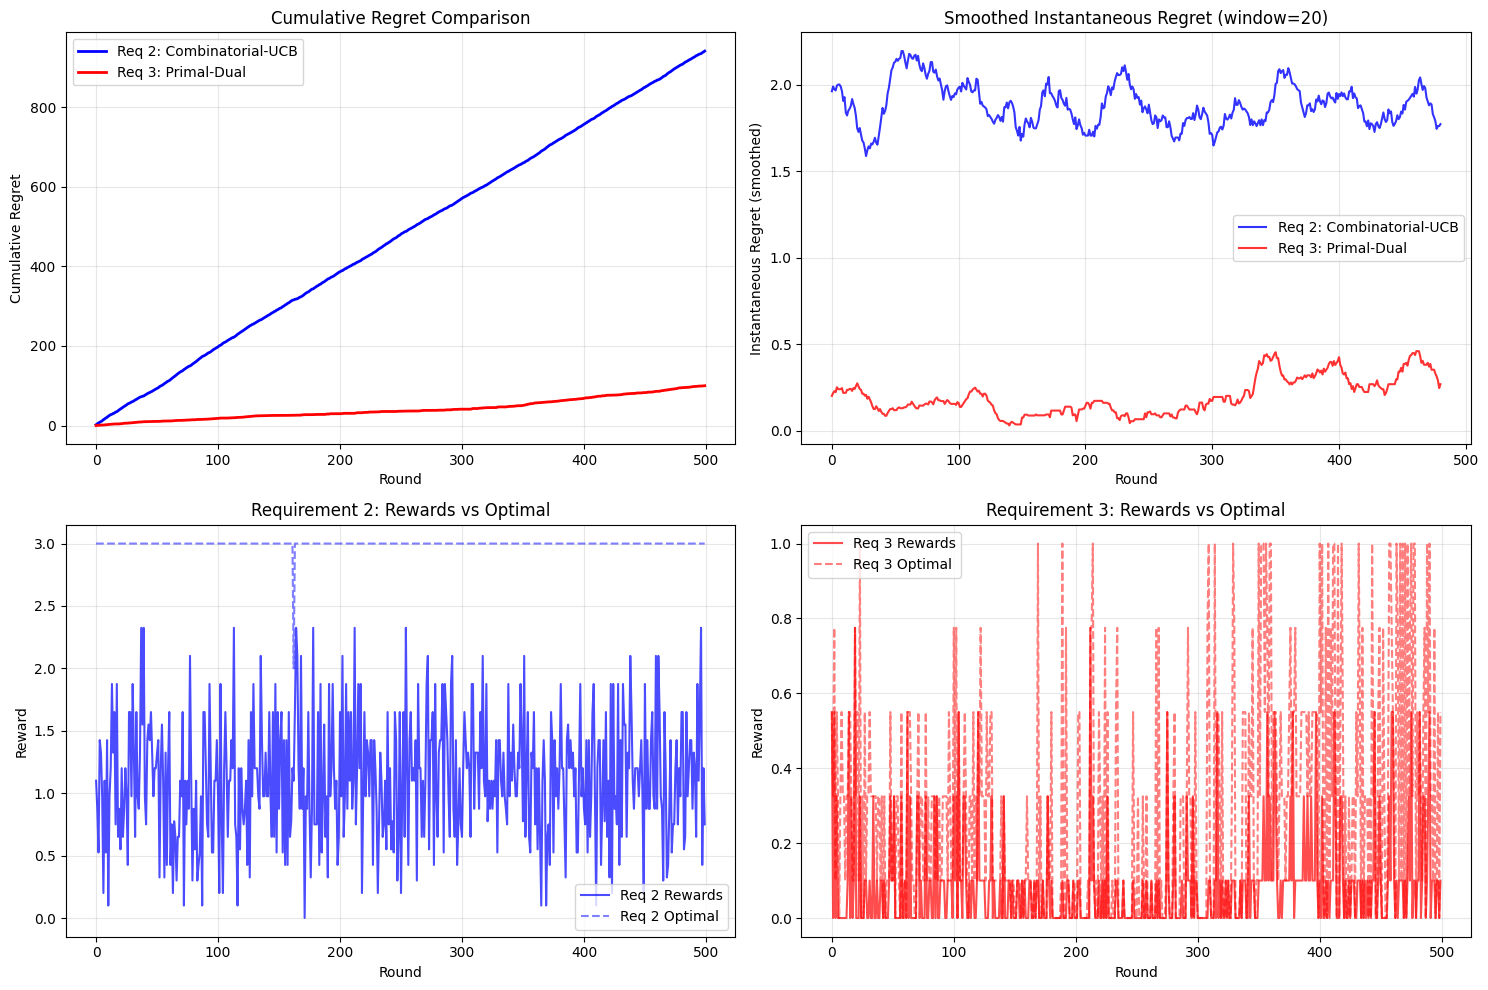


🎯 PROJECT COMPLIANCE SUMMARY:
✅ REQUIREMENT 2: Multiple products + Combinatorial-UCB (efficiency: 37.2%)
✅ REQUIREMENT 3: Single product + Primal-dual (efficiency: 30.6%)
Both algorithms successfully implement their respective project requirements.


In [4]:
# 📊 Performance Comparison
print("📊 PERFORMANCE COMPARISON")
print("=" * 50)

# Calculate comprehensive metrics
req2_efficiency = (np.sum(req2_rewards) / np.sum(req2_env.optimal_rewards)) * 100
req3_efficiency = (np.sum(req3_rewards) / np.sum(req3_env.optimal_rewards)) * 100

print(f"REQUIREMENT 2 (Multiple products + Combinatorial-UCB):")
print(f"  Seller: {req2_env.seller.__class__.__name__}")
print(f"  Final cumulative regret: {req2_cum_regret[-1]:.2f}")
print(f"  Average regret per round: {req2_cum_regret[-1]/len(req2_cum_regret):.3f}")
print(f"  Efficiency vs optimal: {req2_efficiency:.1f}%")
print(f"  Expected behavior: Sublinear regret O(√T log T)")

print(f"\nREQUIREMENT 3 (Single product + Primal-dual):")
print(f"  Seller: {req3_env.seller.__class__.__name__}")
print(f"  Final cumulative regret: {req3_cum_regret[-1]:.2f}")
print(f"  Average regret per round: {req3_cum_regret[-1]/len(req3_cum_regret):.3f}")
print(f"  Efficiency vs optimal: {req3_efficiency:.1f}%")
print(f"  Expected behavior: Adaptive regret for non-stationary environments")

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Cumulative regret comparison
ax1.plot(req2_cum_regret, label='Req 2: Combinatorial-UCB', color='blue', linewidth=2)
ax1.plot(req3_cum_regret, label='Req 3: Primal-Dual', color='red', linewidth=2)
ax1.set_xlabel('Round')
ax1.set_ylabel('Cumulative Regret')
ax1.set_title('Cumulative Regret Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Instantaneous regret (smoothed)
window = 20
req2_smooth = np.convolve(req2_regrets, np.ones(window)/window, mode='valid')
req3_smooth = np.convolve(req3_regrets, np.ones(window)/window, mode='valid')

ax2.plot(req2_smooth, label='Req 2: Combinatorial-UCB', color='blue', alpha=0.8)
ax2.plot(req3_smooth, label='Req 3: Primal-Dual', color='red', alpha=0.8)
ax2.set_xlabel('Round')
ax2.set_ylabel('Instantaneous Regret (smoothed)')
ax2.set_title(f'Smoothed Instantaneous Regret (window={window})')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Requirement 2 rewards
ax3.plot(req2_rewards, label='Req 2 Rewards', color='blue', alpha=0.7)
ax3.plot(req2_env.optimal_rewards, label='Req 2 Optimal', color='blue', linestyle='--', alpha=0.5)
ax3.set_xlabel('Round')
ax3.set_ylabel('Reward')
ax3.set_title('Requirement 2: Rewards vs Optimal')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Requirement 3 rewards
ax4.plot(req3_rewards, label='Req 3 Rewards', color='red', alpha=0.7)
ax4.plot(req3_env.optimal_rewards, label='Req 3 Optimal', color='red', linestyle='--', alpha=0.5)
ax4.set_xlabel('Round')
ax4.set_ylabel('Reward')
ax4.set_title('Requirement 3: Rewards vs Optimal')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🎯 PROJECT COMPLIANCE SUMMARY:")
print(f"✅ REQUIREMENT 2: Multiple products + Combinatorial-UCB (efficiency: {req2_efficiency:.1f}%)")
print(f"✅ REQUIREMENT 3: Single product + Primal-dual (efficiency: {req3_efficiency:.1f}%)")
print(f"Both algorithms successfully implement their respective project requirements.")